<div style="background-color: darkgreen; padding: 10px; color: #F7FF80; border-bottom: 10px solid #BA5E02; border-radius: 10px;">
    <h2 style="margin: 0; padding: 0;">TABLE OF CONTENTS</h2>
</div>

* [<span style="color: darkgreen;">IMPORTS</span>](#1)
* [<span style="color: darkgreen;">INTRODUCTION</span>](#2)
* [<span style="color: darkgreen;">DATA PROCESSING</span>](#3)
* [<span style="color: darkgreen;">PREDICT MEAN QUANTITY</span>](#4)
* [<span style="color: darkgreen;">PREDICT QUANTITY FOR STORES</span>](#5)
* [<span style="color: darkgreen;">CONCLUSION</span>](#6)

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: darkgreen; border-bottom: 10px solid #099A9A; border-radius: 10px;"> Package Imports<br><div> 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras import Sequential, layers

In [4]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: darkgreen; border-bottom: 10px solid #099A9A; border-radius: 10px;"> Introduction<br><div> 

<div class="alert alert-block alert-info" style = "font-family: Cambria Math;font-size: 115%; color: black; background-color: #e6f9ff; border: dashed black 1.0px; padding: 3.5px" >
<p>&emsp; 
    This notebook is for predicting sales quantity in our Dynamic Gridworld challenge. Participants aim to predict product sales in a dynamic 2D world comprising cities and stores.<br>
    The evaluation metric used is the <b>Root Mean Squared Error (RMSE)</b></p>

<p>The approach involves creating two models:</p>
<ul>
   <li>The first model predicts the mean quantity value for each store in each city.</li>
   <li>The second model predicts the quantity for a store relative to the mean quantity in the city.</li>
</ul>
</div>

<a id="3"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: darkgreen; border-bottom: 10px solid #099A9A; border-radius: 10px;"> Data Processing<br><div> 

In [7]:
data_path = "/kaggle/input/predicting-sales-quantity-in-our-dynamic-gridworld"

train = pd.read_csv(f"{data_path}/train.csv")
test = pd.read_csv(f"{data_path}/test.csv")
sup = pd.read_csv(f"{data_path}/supplemental_cities.csv")

train = pd.merge(train, sup, on="city_id")
test = pd.merge(test, sup, on="city_id")

In [8]:
train["type"] = 0
test["type"] = 1
all_data = pd.concat([train, test], axis=0)

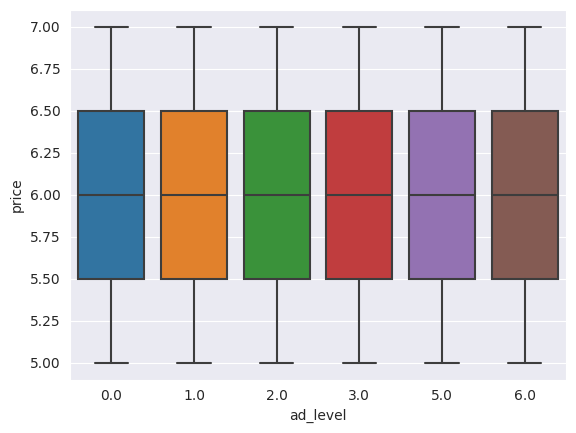

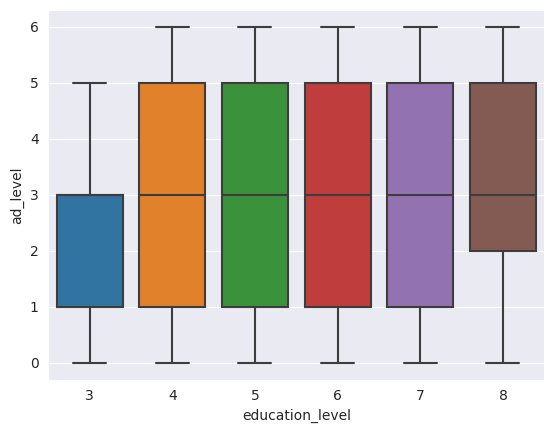

In [9]:
sns.boxplot(y=all_data["price"], x=all_data["ad_level"])
plt.show()
sns.boxplot(y=all_data["ad_level"], x=all_data["education_level"])
plt.show()

In [10]:
all_data["price"].fillna(6.0, inplace=True)
all_data["ad_level"].fillna(3.0, inplace=True)

all_data["population"] = all_data["population"].fillna(train["population"].mean())
all_data["median_income"] = all_data["median_income"].fillna(train["median_income"].mean())

all_data["ad_level"] += 1

In [11]:
all_data["no_stores"] = all_data.groupby("city_id").transform("size")

all_data["x"] = all_data["city_id"].str.split("/").str[0]
all_data["x"] = all_data["x"].astype(int) + 1
all_data["y"] = all_data["city_id"].str.split("/").str[1]
all_data["y"] = all_data['y'].astype(int) + 1
all_data["length"] = (all_data["x"] ** 2 + all_data["y"] ** 2) ** 0.5
all_data["cos"] = all_data["x"] / all_data["length"]
all_data["city_nr"] = all_data["city_id"].str.split("/").str[2]
all_data["city_nr"] = all_data["city_nr"].astype(int)

all_data["education_to_population_ratio"] = all_data["education_level"] / all_data["population"]
all_data["population_education_product"] = all_data["population"] * all_data["education_level"]

all_data["price_ad_interaction"] = all_data["price"] * all_data["ad_level"]
all_data["price_population_interaction"] = all_data["price"] * all_data["population"]
all_data["price_education_interaction"] = all_data["price"] * all_data["education_level"]
all_data["price_income_interaction"] = all_data["price"] * all_data["median_income"]

all_data["mean_price_ad_interaction"] = all_data.groupby("city_id")["price_ad_interaction"].transform("mean")
all_data["mean_price_population_interaction"] = all_data.groupby("city_id")["price_population_interaction"].transform(
    "mean")
all_data["mean_price_education_interaction"] = all_data.groupby("city_id")["price_education_interaction"].transform(
    "mean")
all_data["mean_price_income_interaction"] = all_data.groupby("city_id")["price_income_interaction"].transform("mean")

all_data["mean_price"] = all_data.groupby("city_id")["price"].transform("mean")
all_data["mean_ad_level"] = all_data.groupby("city_id")["ad_level"].transform("mean")
all_data["mean_quantity"] = all_data.groupby("city_id")["quantity"].transform("mean")

<a id="4"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: darkgreen; border-bottom: 10px solid #099A9A; border-radius: 10px;"> Predict Mean Quantity<br><div> 

In [12]:
cities_df = all_data.copy()
cities_df.drop_duplicates("city_id", inplace=True)
test_cities = cities_df[cities_df["type"] == 1][["city_id"]]

In [13]:
drop_list = ["id", "city_id", "store_id", "ad_level", "price", "quantity", "price_ad_interaction",
             "price_population_interaction", "price_education_interaction", "price_income_interaction"]
cities_df.drop(columns=drop_list, inplace=True)

In [14]:
cities_df.head(6)

,population,education_level,median_income,type,no_stores,x,y,length,cos,city_nr,education_to_population_ratio,population_education_product,mean_price_ad_interaction,mean_price_population_interaction,mean_price_education_interaction,mean_price_income_interaction,mean_price,mean_ad_level,mean_quantity
0,9868.0,5,1478.732661,0,1,1,1,1.414214,0.707107,0,0.000507,49340.0,42.00,59208.00,30.00,8872.395966,6.00,7.0,2240.0
1,7446.0,6,1612.926622,0,1,1,5,5.099020,0.196116,0,0.000806,44676.0,24.00,44676.00,36.00,9677.559731,6.00,4.0,2558.0
2,2029.0,5,1403.120891,0,1,1,10,10.049876,0.099504,1,0.002464,10145.0,15.75,10652.25,26.25,7366.384678,5.25,3.0,2316.0
3,4418.0,6,1555.556995,0,1,1,12,12.041595,0.083045,0,0.001358,26508.0,37.50,27612.50,37.50,9722.231216,6.25,6.0,2276.0
4,3932.0,5,1431.114759,0,1,1,14,14.035669,0.071247,0,0.001272,19660.0,18.00,23592.00,30.00,8586.688555,6.00,3.0,1800.0
5,3218.0,5,1343.638980,0,1,1,16,16.031220,0.062378,0,0.001554,16090.0,36.75,16894.50,26.25,7054.104643,5.25,7.0,2640.0


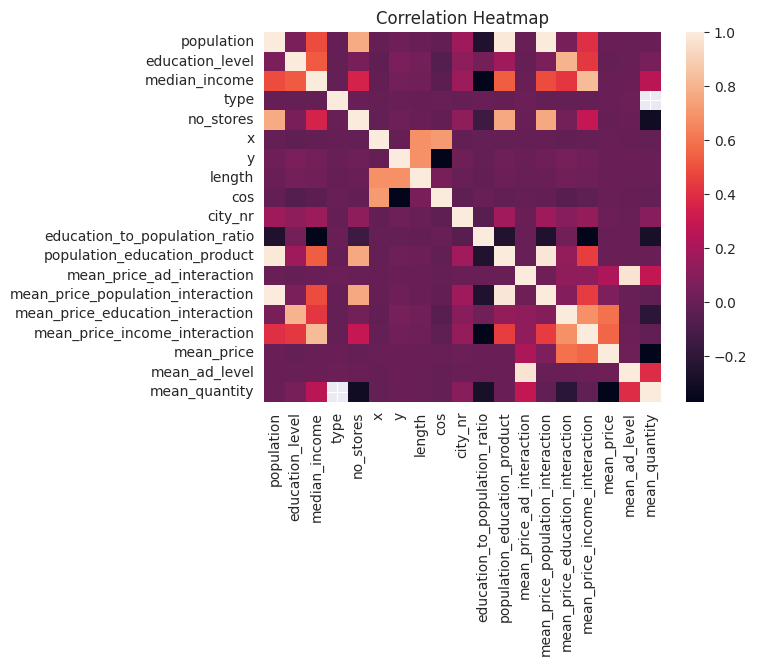

In [15]:
sns.heatmap(cities_df.corr(numeric_only=True), robust=True)
plt.title("Correlation Heatmap")
plt.show()

In [16]:
scaler = MinMaxScaler((0, 1))

scaler_list = cities_df.columns.drop("mean_quantity")
cities_df[scaler_list] = scaler.fit_transform(cities_df[scaler_list])
cities_df["mean_quantity"] = scaler.fit_transform(cities_df[["mean_quantity"]])  # save this scaler to inverse predict in the future

In [17]:
train = cities_df[cities_df.type == 0]
train = train.drop(columns=["type"])
train.reset_index(inplace=True, drop=True)
test = cities_df[cities_df.type == 1]
test = test.drop(columns=["type", "mean_quantity"])
test.reset_index(inplace=True, drop=True)

In [18]:
y = train[["mean_quantity"]]
X = train.drop(columns="mean_quantity")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [19]:
def get_mean_quantity_predict_model() -> Sequential:
    m = Sequential()
    m.add(layers.Dense(32, activation="relu", input_shape=(X.shape[-1],)))  # 28
    m.add(layers.Dense(24, activation="relu"))  # 14
    m.add(layers.Dense(6, activation="relu"))
    m.add(layers.Dense(1, activation="linear"))

    m.compile(optimizer="adam", loss="mean_squared_error")
    return m

epochs = 160
batch_size = 54

In [20]:
model = get_mean_quantity_predict_model()
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, validation_split=0.15)

y_test_predict = scaler.inverse_transform(model.predict(X_test))
y_test_true = scaler.inverse_transform(y_test)
print(f"Mean Squared Error: {np.sqrt(mean_squared_error(y_test_true, y_test_predict))}")

Epoch 1/160
179/179 - 1s - loss: 0.0095 - val_loss: 0.0069 - 1s/epoch - 7ms/step
Epoch 2/160
179/179 - 0s - loss: 0.0059 - val_loss: 0.0048 - 197ms/epoch - 1ms/step
Epoch 3/160
179/179 - 0s - loss: 0.0045 - val_loss: 0.0041 - 204ms/epoch - 1ms/step
Epoch 4/160
179/179 - 0s - loss: 0.0039 - val_loss: 0.0037 - 219ms/epoch - 1ms/step
Epoch 5/160
179/179 - 0s - loss: 0.0036 - val_loss: 0.0046 - 192ms/epoch - 1ms/step
Epoch 6/160
179/179 - 0s - loss: 0.0034 - val_loss: 0.0040 - 186ms/epoch - 1ms/step
Epoch 7/160
179/179 - 0s - loss: 0.0033 - val_loss: 0.0032 - 187ms/epoch - 1ms/step
Epoch 8/160
179/179 - 0s - loss: 0.0032 - val_loss: 0.0032 - 184ms/epoch - 1ms/step
Epoch 9/160
179/179 - 0s - loss: 0.0032 - val_loss: 0.0032 - 180ms/epoch - 1ms/step
Epoch 10/160
179/179 - 0s - loss: 0.0030 - val_loss: 0.0034 - 186ms/epoch - 1ms/step
Epoch 11/160
179/179 - 0s - loss: 0.0031 - val_loss: 0.0031 - 180ms/epoch - 1ms/step
Epoch 12/160
179/179 - 0s - loss: 0.0030 - val_loss: 0.0032 - 181ms/epoch - 1

In [21]:
final_model = get_mean_quantity_predict_model()
final_model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

In [22]:
test_predict = scaler.inverse_transform(final_model.predict(test))
test_cities["mean_quantity"] = test_predict

263/263 [==============================] - 0s 846us/step


In [23]:
all_data = all_data.merge(test_cities, on="city_id", how="left")

nan_mask = all_data["mean_quantity_x"].isna()
all_data.loc[nan_mask, "mean_quantity_x"] = all_data[nan_mask]["mean_quantity_y"]
all_data.drop(columns="mean_quantity_y", inplace=True)
all_data.head(6)

,id,city_id,price,store_id,quantity,ad_level,population,education_level,median_income,type,no_stores,x,y,length,cos,city_nr,education_to_population_ratio,population_education_product,price_ad_interaction,price_population_interaction,price_education_interaction,price_income_interaction,mean_price_ad_interaction,mean_price_population_interaction,mean_price_education_interaction,mean_price_income_interaction,mean_price,mean_ad_level,mean_quantity_x
0,0,0/0/0,6.00,0,2240.0,7.0,9868.0,5,1478.732661,0,1,1,1,1.414214,0.707107,0,0.000507,49340.0,42.00,59208.00,30.00,8872.395966,42.00,59208.00,30.00,8872.395966,6.00,7.0,2240.0
1,3,0/4/0,6.00,0,2558.0,4.0,7446.0,6,1612.926622,0,1,1,5,5.099020,0.196116,0,0.000806,44676.0,24.00,44676.00,36.00,9677.559731,24.00,44676.00,36.00,9677.559731,6.00,4.0,2558.0
2,11,0/9/1,5.25,0,2316.0,3.0,2029.0,5,1403.120891,0,1,1,10,10.049876,0.099504,1,0.002464,10145.0,15.75,10652.25,26.25,7366.384678,15.75,10652.25,26.25,7366.384678,5.25,3.0,2316.0
3,14,0/11/0,6.25,0,2276.0,6.0,4418.0,6,1555.556995,0,1,1,12,12.041595,0.083045,0,0.001358,26508.0,37.50,27612.50,37.50,9722.231216,37.50,27612.50,37.50,9722.231216,6.25,6.0,2276.0
4,15,0/13/0,6.00,0,1800.0,3.0,3932.0,5,1431.114759,0,1,1,14,14.035669,0.071247,0,0.001272,19660.0,18.00,23592.00,30.00,8586.688555,18.00,23592.00,30.00,8586.688555,6.00,3.0,1800.0
5,16,0/15/0,5.25,0,2640.0,7.0,3218.0,5,1343.638980,0,1,1,16,16.031220,0.062378,0,0.001554,16090.0,36.75,16894.50,26.25,7054.104643,36.75,16894.50,26.25,7054.104643,5.25,7.0,2640.0


<a id="5"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: darkgreen; border-bottom: 10px solid #099A9A; border-radius: 10px;"> Predict Quantity for Stores<br><div> 

In [24]:
columns = ["id", "city_id", "store_id", "price", "ad_level", "quantity", "type", 
           "no_stores", "city_nr", "mean_quantity_x"]
stores_data = all_data[columns].copy()

In [25]:
stores_data.head(6)

,id,city_id,store_id,price,ad_level,quantity,type,no_stores,city_nr,mean_quantity_x
0,0,0/0/0,0,6.00,7.0,2240.0,0,1,0,2240.0
1,3,0/4/0,0,6.00,4.0,2558.0,0,1,0,2558.0
2,11,0/9/1,0,5.25,3.0,2316.0,0,1,1,2316.0
3,14,0/11/0,0,6.25,6.0,2276.0,0,1,0,2276.0
4,15,0/13/0,0,6.00,3.0,1800.0,0,1,0,1800.0
5,16,0/15/0,0,5.25,7.0,2640.0,0,1,0,2640.0


In [26]:
stores_data.loc[:, "price"] /= stores_data.groupby("city_id")["price"].transform("max")
stores_data.loc[:, "ad_level"] /= stores_data.groupby("city_id")["ad_level"].transform("max")
stores_data.loc[:, "quantity"] /= stores_data["mean_quantity_x"]

stores_data.loc[:, "no_stores"] /= stores_data["no_stores"].max()
stores_data.loc[:, "city_nr"] /= stores_data["city_nr"].max()

In [27]:
stores_data.head(6)

,id,city_id,store_id,price,ad_level,quantity,type,no_stores,city_nr,mean_quantity_x
0,0,0/0/0,0,1.0,1.0,1.0,0,0.033333,0.0,2240.0
1,3,0/4/0,0,1.0,1.0,1.0,0,0.033333,0.0,2558.0
2,11,0/9/1,0,1.0,1.0,1.0,0,0.033333,0.5,2316.0
3,14,0/11/0,0,1.0,1.0,1.0,0,0.033333,0.0,2276.0
4,15,0/13/0,0,1.0,1.0,1.0,0,0.033333,0.0,1800.0
5,16,0/15/0,0,1.0,1.0,1.0,0,0.033333,0.0,2640.0


<div class="alert alert-block alert-info" style = "font-family: Cambria Math;font-size: 115%; color: black; background-color: #e6f9ff; border: dashed black 1.0px; padding: 3.5px" >
The main idea is to restructure and encode store-related data for each city. This restructuring involves pivoting the data, so each city has columns for ad_level, price, quantity, and id, for each store. After this transformation, duplicate city entries are dropped to retain only unique city records.<br>
</div>

In [28]:
for c, suff in zip(["ad_level", "price", "quantity", "id"], [("", ""), ("_a", "_p"), ("", ""), ("_q", "_id")]):
    pivot_df = stores_data.pivot(index="city_id", columns="store_id", values=[c])
    if c != "id":
        pivot_df.fillna(0, inplace=True)
    stores_data = stores_data.merge(pivot_df[c], on="city_id", how="left", suffixes=suff)

mean_quantity_df = stores_data[["id", "mean_quantity_x"]]
stores_data.drop_duplicates("city_id", inplace=True)

ids = [f"{i}_id" for i in range(30)]
test_ids = stores_data[stores_data["type"] == 1][ids].values

stores_data.drop(columns=["id", "city_id", "store_id", "ad_level", "price", "quantity", *ids], inplace=True)

In [29]:
stores_data.sort_values("no_stores", ascending=False).head(6)

,type,no_stores,city_nr,mean_quantity_x,0_a,1_a,2_a,3_a,4_a,5_a,6_a,7_a,8_a,9_a,10_a,11_a,12_a,13_a,14_a,15_a,16_a,17_a,18_a,19_a,20_a,21_a,22_a,23_a,24_a,25_a,26_a,27_a,28_a,29_a,0_p,1_p,2_p,3_p,4_p,5_p,6_p,7_p,8_p,9_p,10_p,11_p,12_p,13_p,14_p,15_p,16_p,17_p,18_p,19_p,20_p,21_p,22_p,23_p,24_p,25_p,26_p,27_p,28_p,29_p,0_q,1_q,2_q,3_q,4_q,5_q,6_q,7_q,8_q,9_q,10_q,11_q,12_q,13_q,14_q,15_q,16_q,17_q,18_q,19_q,20_q,21_q,22_q,23_q,24_q,25_q,26_q,27_q,28_q,29_q
28890,1,1.000000,0.5,800.273865,1.000000,0.571429,0.428571,0.571429,0.142857,1.000000,0.285714,1.000000,0.857143,0.571429,0.571429,0.571429,0.571429,0.285714,0.571429,0.142857,0.571429,0.571429,0.571429,0.428571,0.428571,1.000000,0.142857,0.571429,0.285714,0.285714,0.571429,0.571429,0.857143,0.571429,0.785714,0.750000,0.857143,1.000000,0.964286,0.892857,0.714286,1.000000,0.785714,0.821429,0.821429,0.928571,0.821429,0.892857,0.714286,0.964286,0.928571,0.714286,0.857143,0.928571,0.785714,0.857143,0.714286,0.857143,0.785714,0.75,0.928571,0.857143,0.714286,0.892857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6811,0,0.766667,0.0,741.913043,0.857143,0.571429,1.000000,0.428571,0.571429,0.857143,1.000000,0.571429,0.428571,0.571429,0.285714,0.857143,0.428571,0.857143,0.571429,1.000000,0.857143,1.000000,0.857143,0.285714,0.857143,0.571429,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.821429,0.750000,0.892857,1.000000,0.821429,0.928571,0.821429,0.821429,0.750000,0.928571,1.000000,0.857143,0.892857,0.928571,0.821429,0.857143,0.821429,0.892857,0.714286,1.000000,0.714286,1.000000,0.892857,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,1.121425,1.173992,1.051336,0.703586,1.071554,0.992030,1.142991,1.106599,0.938115,0.947550,0.586322,1.07425,0.788502,0.992030,1.071554,0.938115,1.121425,1.051336,1.289909,0.586322,1.289909,0.90981,1.051336,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22548,1,0.700000,0.5,727.078552,0.428571,0.428571,0.571429,0.142857,0.571429,0.285714,0.571429,0.571429,0.571429,0.285714,0.571429,0.571429,0.571429,0.142857,0.571429,0.571429,1.000000,0.428571,0.571429,1.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.821429,0.785714,0.928571,0.750000,0.964286,0.750000,1.000000,0.785714,0.857143,0.750000,0.714286,0.821429,1.000000,0.750000,0.928571,0.857143,0.857143,0.928571,0.714286,0.714286,0.857143,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27797,1,0.633333,0.0,687.197998,0.571429,0.285714,1.000000,0.428571,0.428571,0.571429,0.142857,0.571429,0.142857,0.857143,0.285714,0.571429,0.571429,0.428571,0.142857,1.000000,0.142857,0.571429,0.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.785714,0.857143,0.821429,0.750000,0.928571,0.821429,0.821429,0.750000,0.964286,0.785714,0.750000,1.000000,0.714286,0.750000,1.000000,0.857143,0.857143,0.750000,0.928571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25936,1,0.633333,0.5,672.490295,0.285714,0.857143,0.285714,1.000000,0.571429,0.571429,0.142857,0.571429,0.142857,0.571429,0.428571,0.285714,0.142857,0.571429,0.428571,0.571429,0.571429,0.571429,0.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.821429,0.892857,1.000000,0.714286

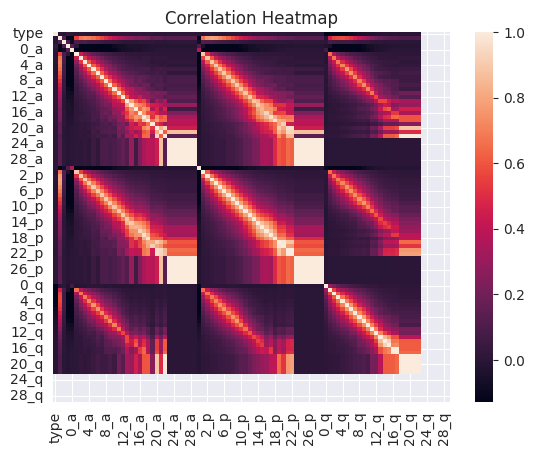

In [30]:
sns.heatmap(stores_data.corr(numeric_only=True), robust=True)
plt.title("Correlation Heatmap")
plt.show()

In [31]:
train = stores_data[stores_data.type == 0]
train = train.drop(columns=["type"])
train.reset_index(inplace=True, drop=True)
test = stores_data[stores_data.type == 1]
test = test.drop(columns=["type"])
test.reset_index(inplace=True, drop=True)

In [32]:
test.head(6)

,no_stores,city_nr,mean_quantity_x,0_a,1_a,2_a,3_a,4_a,5_a,6_a,7_a,8_a,9_a,10_a,11_a,12_a,13_a,14_a,15_a,16_a,17_a,18_a,19_a,20_a,21_a,22_a,23_a,24_a,25_a,26_a,27_a,28_a,29_a,0_p,1_p,2_p,3_p,4_p,5_p,6_p,7_p,8_p,9_p,10_p,11_p,12_p,13_p,14_p,15_p,16_p,17_p,18_p,19_p,20_p,21_p,22_p,23_p,24_p,25_p,26_p,27_p,28_p,29_p,0_q,1_q,2_q,3_q,4_q,5_q,6_q,7_q,8_q,9_q,10_q,11_q,12_q,13_q,14_q,15_q,16_q,17_q,18_q,19_q,20_q,21_q,22_q,23_q,24_q,25_q,26_q,27_q,28_q,29_q
0,0.066667,0.0,3059.240234,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.869565,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.033333,0.0,2294.565186,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.033333,0.0,3006.075928,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.033333,0.5,2732.978760,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.066667,0.0,2688.246826,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.814815,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.066667,0.0,3482.148193,0.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.869565,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
quantity_columns = [f"{i}_q" for i in range(30)]
test.drop(columns=[*quantity_columns, "mean_quantity_x"], inplace=True)

y = train[quantity_columns]
X = train.drop(columns=quantity_columns)

In [34]:
test_len = -int(12583 * 0.75)
X_train = X[test_len:].drop(columns="mean_quantity_x")
X_test = X[:test_len]
X.drop(columns="mean_quantity_x", inplace=True)
mean_quantity = X_test["mean_quantity_x"].values
X_test = X_test.drop(columns="mean_quantity_x")

y_train = y[test_len:]
y_test = y[:test_len]
y_test = y_test.mul(mean_quantity, axis=0).values

test_mask = np.where(y_test[:] != 0)
y_test = y_test[test_mask]

In [35]:
def get_model() -> Sequential:
    m = Sequential()
    m.add(layers.Dense(64, activation="relu", input_shape=(X_train.shape[-1],)))
    m.add(layers.Dense(30, activation="linear"))

    m.compile(optimizer="adam", loss="mean_squared_error")
    return m

epochs = 320
batch_size = 84

In [36]:
model = get_model()
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.15)
# ~ 3 min

In [37]:
y_pred = model.predict(X_test)
for i, q in enumerate(mean_quantity):
    y_pred[i] *= q
print(f"Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred[test_mask]))}")

99/99 [==============================] - 0s 741us/step
Mean Squared Error: 121.45270362953006


<div class="alert alert-block alert-info" style = "font-family: Cambria Math;font-size: 115%; color: black; background-color: #e6f9ff; border: dashed black 1.0px; padding: 3.5px" >
&emsp; As you can see, the score is quite impressive. However, this achievement is based on fact that the training data contains the true mean quantity values.<br> 
&emsp; On the test dataset, with the predicted mean quantity column, the results may not be as favorable.<br>
</div>

In [38]:
final_model = get_model()
final_model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)  # ~ 3 min

In [42]:
test_predict = final_model.predict(test)
result_df = pd.DataFrame({"id": test_ids.flatten(), "quantity": test_predict.flatten()})
result_df = result_df.dropna()
result_df = result_df.merge(mean_quantity_df, how="left", on="id")
result_df.loc[:, "quantity"] *= result_df["mean_quantity_x"]
result_df.loc[result_df["quantity"] < 200, "quantity"] = 200

result_df.drop(columns="mean_quantity_x", inplace=True)
result_df = result_df.astype(np.int32)
result_df.to_csv("result.csv", index=False)

# ~ 290 score

263/263 [==============================] - 0s 942us/step


<a id="6"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: darkgreen; border-bottom: 10px solid #099A9A; border-radius: 10px;"> CONCLUSION<br><div>  

<div class="alert alert-block alert-info" style = "font-family: Cambria Math;font-size: 115%; color: black; background-color: #e6f9ff; border: dashed black 1.0px; padding: 3.5px" >
<b>Next steps</b> <br>
1. Increase the mean quantity prediction metric.<br>
2. There are some cities with just one store. These cities can be processed separately.<br>
3. Experiment with alternative models for prediction.<br>
</div>